# LSTM Analysis 

Long Short-Term Memory (LSTM) networks, a special kind of Recurrent Neural Network (RNN), have emerged as a powerful tool for predicting time series data due to their ability to capture long-term dependencies and patterns. Unlike traditional neural networks, LSTMs can remember information over extended periods, making them particularly suitable for applications where historical context significantly influences future outcomes. This capability is especially valuable in financial markets, where past stock prices and trends can provide insightful cues for future movements.

In this analysis, we leverage the strengths of LSTM networks to predict the stock price of the Vanguard S&P 500 ETF ($VOO), a task of significant interest for investors and financial analysts alike.


### 0. Importing Modules

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import seaborn as sns

import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

### 1. Data Preparation



In [52]:
voo_data = pd.read_csv('../datasets/VOO.csv')
df = pd.read_csv('../datasets/VOO.csv')
display(voo_data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2021,354.549988,359.390015,354.500000,358.119995,341.877502,3721100
1,3/2/2021,358.380005,358.630005,355.160004,355.350006,339.233154,5462600
2,3/3/2021,354.700012,355.640015,350.559998,350.660004,334.755859,6317600
3,3/4/2021,350.489990,353.019989,341.920013,346.339996,330.631775,6604500
4,3/5/2021,349.769989,353.730011,342.589996,352.690002,336.693817,8721300
...,...,...,...,...,...,...,...
499,2/22/2023,367.179993,368.600006,364.839996,366.329987,360.530518,3872000
500,2/23/2023,369.070007,369.570007,364.130005,368.170013,362.341400,2867200
501,2/24/2023,363.309998,365.029999,361.730011,364.230011,358.463776,4055000
502,2/27/2023,367.489990,368.769989,364.589996,365.489990,359.703796,3300100


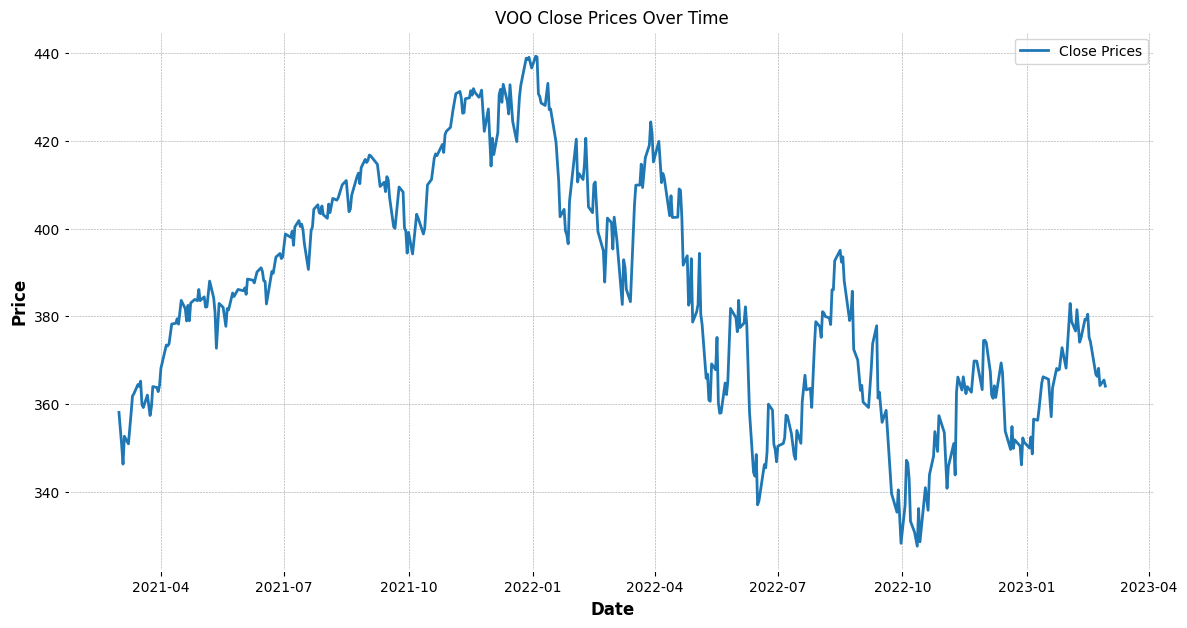

In [53]:
# Convert the 'Date' column to datetime format and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Now, focus on the 'Close' column
df_close = df[['Close']]

plt.figure(figsize=(14, 7))
plt.plot(df['Close'], label='Close Prices')
plt.title('VOO Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


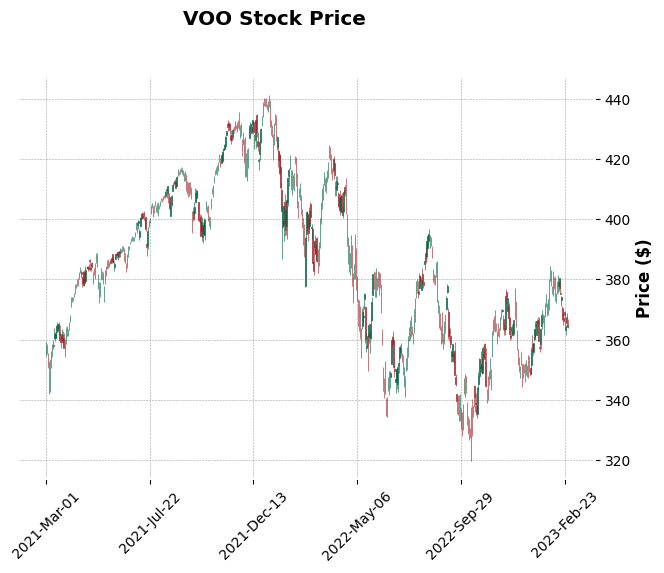

In [56]:
# Since mplfinance expects certain column names for the OHLC data, ensure your DataFrame columns are named appropriately
df = df[['Open', 'High', 'Low', 'Close']]

# Create the candlestick chart
mpf.plot(df, type='candle', style='charles', title='VOO Stock Price', ylabel='Price ($)')

### 2. Exploratory Data Analysis


In [58]:
#Summary Statistics
print(voo_data.describe())

             Open        High         Low       Close   Adj Close  \
count  504.000000  504.000000  504.000000  504.000000  504.000000   
mean   385.155834  387.694881  382.425418  385.225773  373.208588   
std     26.709360   26.281009   26.945778   26.639721   24.477711   
min    320.839996  330.579987  319.869995  327.640015  320.916229   
25%    362.904992  365.584999  360.562508  363.569992  354.517654   
50%    383.725006  385.555008  381.470001  383.544999  370.726868   
75%    407.182510  409.052490  404.282509  406.889992  392.188247   
max    440.579987  441.260010  437.660004  439.250000  425.171234   

             Volume  
count  5.040000e+02  
mean   5.084478e+06  
std    2.479813e+06  
min    1.423400e+06  
25%    3.460450e+06  
50%    4.470550e+06  
75%    5.875400e+06  
max    2.297070e+07  


In [59]:
# Check for Missing Values
print(voo_data.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


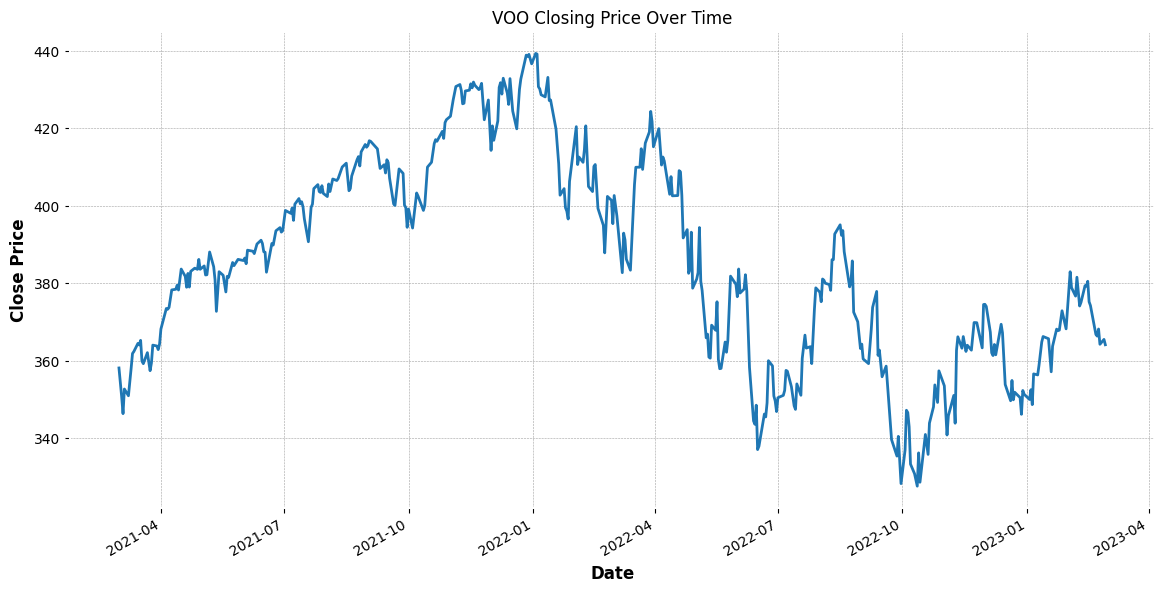

In [60]:
#Plotting the Closing Price Over Time
df['Close'].plot(figsize=(14, 7), title='VOO Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

C:\Users\TAN UEI HORNG\AppData\Local\Temp\ipykernel_30000\2787168753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MA50'] = df['Close'].rolling(50).mean()


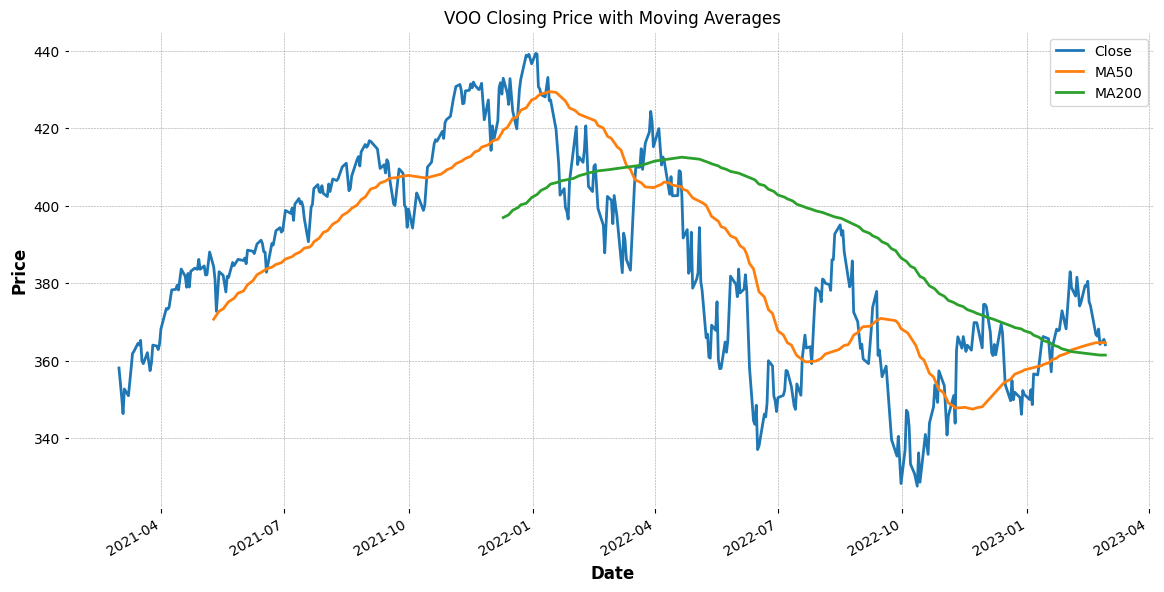

In [61]:
# Moving Averages
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()

df[['Close', 'MA50', 'MA200']].plot(figsize=(14, 7), title='VOO Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

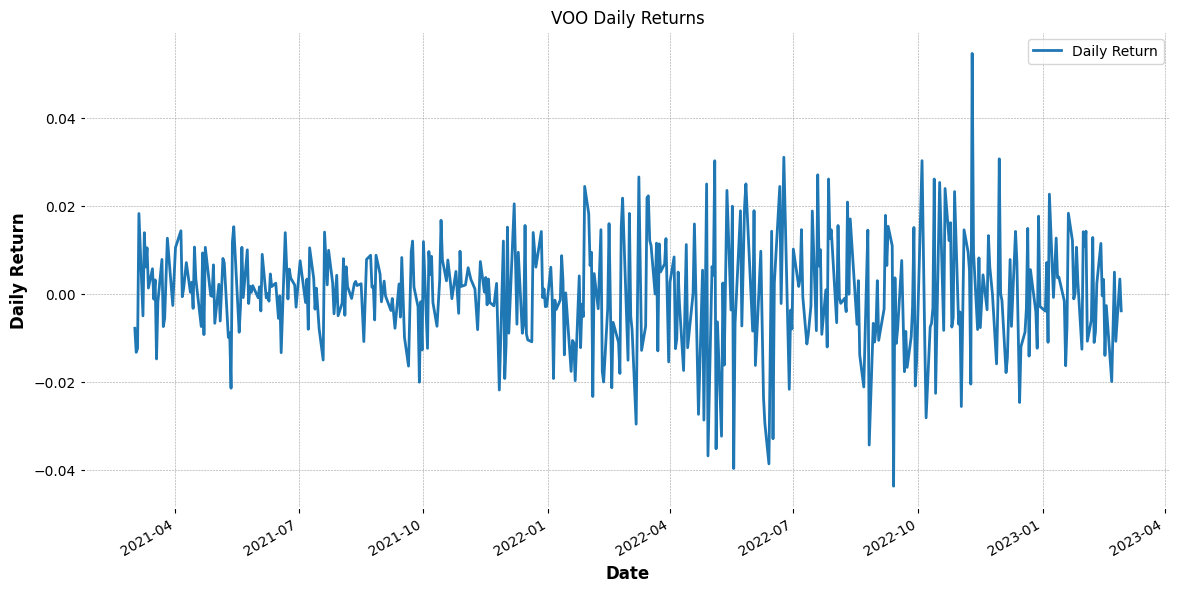

In [62]:
# Daily Returns
df['Daily Return'] = df['Close'].pct_change()
df['Daily Return'].plot(figsize=(14, 7), legend=True, title='VOO Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()


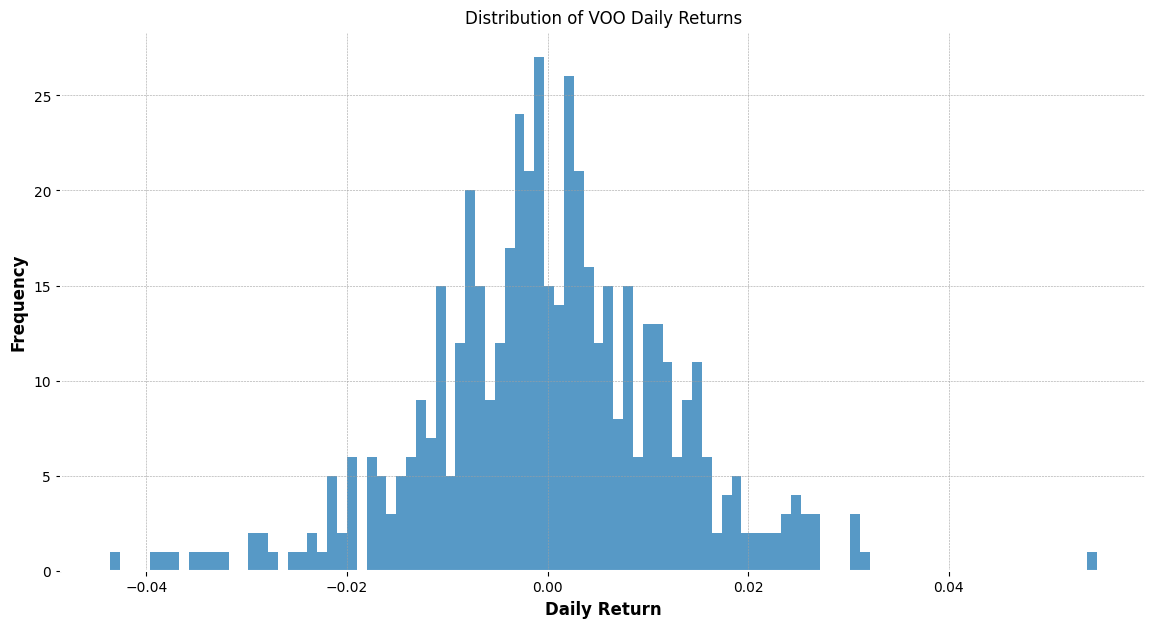

In [63]:
# Distribution of Daily Returns
df['Daily Return'].hist(bins=100, alpha=0.75, figsize=(14, 7))
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.title('Distribution of VOO Daily Returns')
plt.show()


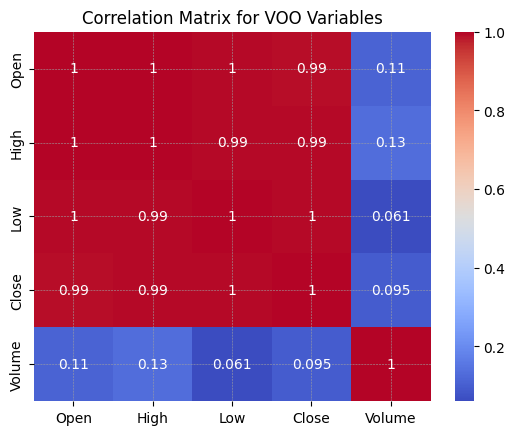

In [66]:
# Correlation Matrix
correlation_matrix = voo_data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for VOO Variables')
plt.show()




---

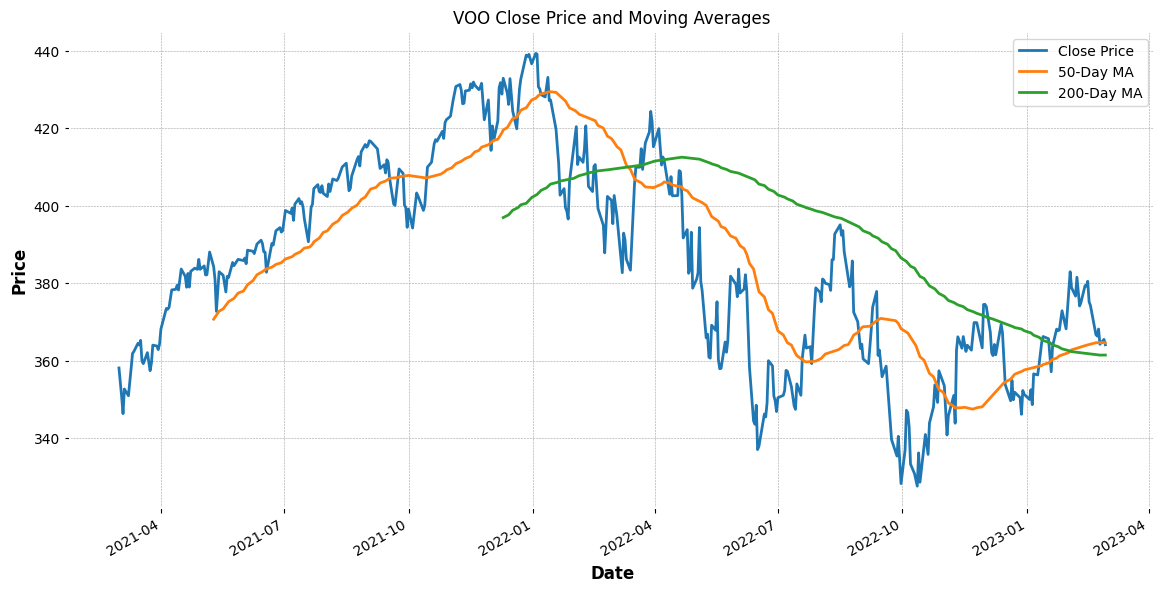

In [67]:
# Closing Price and Moving Averages on One Chart

plt.figure(figsize=(14, 7))

# Plotting the Closing Price
df['Close'].plot(label='Close Price')

# Short-term (50-day) and Long-term (200-day) Moving Averages
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()
df['MA50'].plot(label='50-Day MA')
df['MA200'].plot(label='200-Day MA')

plt.title('VOO Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In the chart, the MA200 starts later than the MA50 (50-day moving average) and the closing price line. This happens because a 200-day moving average requires 200 days of data before the first value can be calculated. Therefore, the MA200 line will begin to appear on the chart only after the first 200 days.

The 200-day moving average is used to determine the long-term market trend and smooth out price fluctuations. It's slower to respond to price changes than the 50-day moving average because it considers a larger set of data, which is why it appears smoother and starts later in the chart.

The overall chart shows the closing price of VOO, along with the short-term (MA50) and long-term (MA200) trends. The MA50 line reacts more quickly to recent price changes, while the MA200 provides a more gradual trend line that reflects longer-term price movements. When the closing price dips below these averages, it could be seen as a bearish signal, and when it's above, it could be bullish. The intersection points where the closing price or MA50 crosses the MA200 can be of particular interest to traders looking for trend reversals.

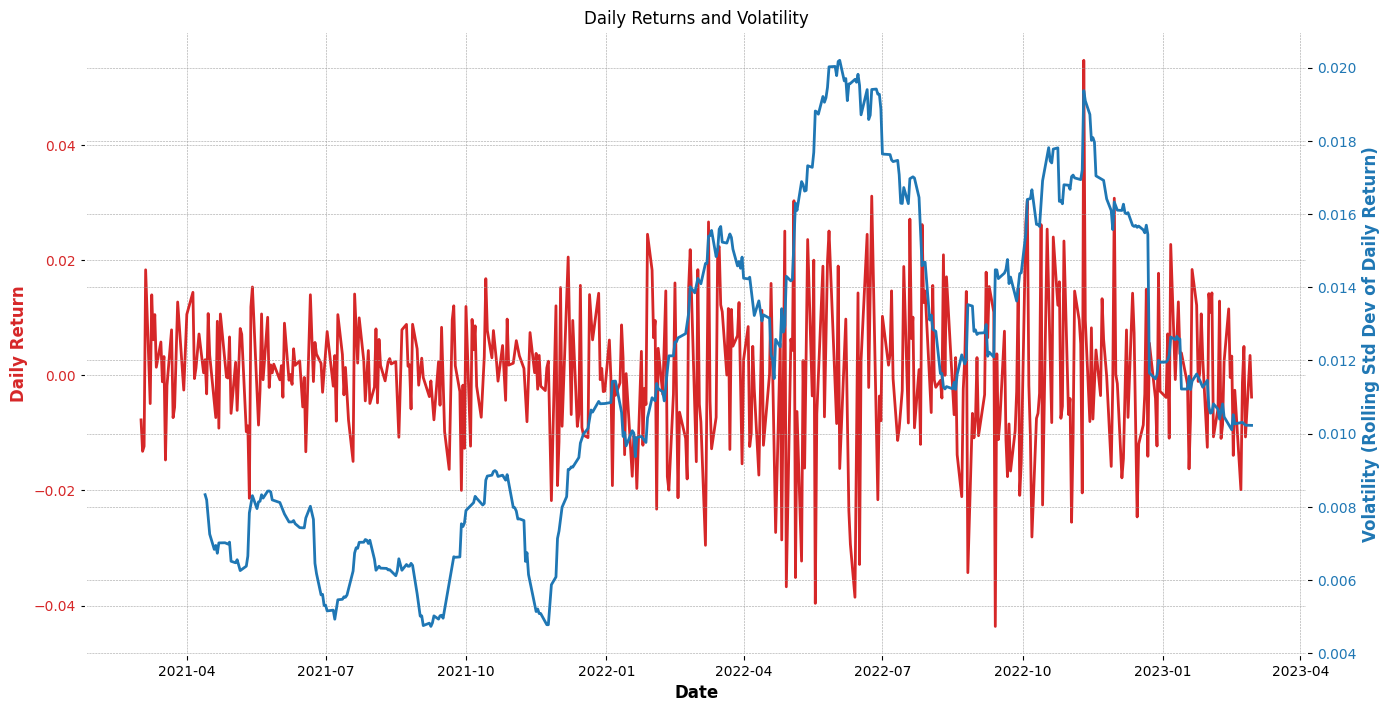

In [68]:
# Daily Returns and Volatility in a Single Chart
df['Daily Return'] = df['Close'].pct_change()

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Return', color=color)
ax1.plot(df.index, df['Daily Return'], color=color, label='Daily Return')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Volatility (Rolling Std Dev of Daily Return)', color=color)  
ax2.plot(df.index, df['Daily Return'].rolling(window=30).std(), color=color, label='Rolling 30-Day Std Dev')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Daily Returns and Volatility')
plt.show()


---


### 3. Test & Training Set Preparation and Data Normalisation

---

### 4. LSTM Model Building & Training

---

### 5. Predictions and Visualization

---

### 6. Evaluation & Observation

---